# Eficiencia vs. Métricas de Rendimiento

¡Bienvenido! En este laboratorio práctico, explorarás el equilibrio crucial entre el rendimiento de un modelo y su eficiencia. Como has aprendido, construir soluciones de Machine Learning efectivas implica mucho más que solo apuntar a la mayor precisión posible. Las aplicaciones en el mundo real suelen tener límites estrictos en el tamaño del modelo, el tiempo de inferencia y el uso de memoria que debes considerar junto con el poder predictivo.

En este notebook, adoptarás un enfoque sistemático para comparar y seleccionar modelos combinando estándares tanto de rendimiento como de eficiencia.

Específicamente, aprenderás a:

* **Entrenar diversos modelos**: Entrenarás dos redes neuronales convolucionales diferentes en el dataset CIFAR10: una CNN compacta y ligera, y la arquitectura más profunda ResNet34.

* **Evaluar métricas de eficiencia clave**: Utilizarás funciones auxiliares (utility functions) para medir y analizar el tamaño de cada modelo, su velocidad de inferencia y su huella de memoria.

* **Aplicar estrategias de selección de modelos**: Experimentarás con dos métodos para elegir el mejor modelo: un sistema de puntuación ponderada (weighted scoring) que equilibra múltiples factores y un enfoque basado en restricciones (constraint-based) que filtra modelos según límites estrictos.

Al practicar estas estrategias, obtendrás experiencia práctica en equilibrar la complejidad del modelo con la calidad predictiva. Estas habilidades son esenciales para diseñar y desplegar sistemas de Deep Learning robustos y eficientes en entornos de producción.

## Imports

In [1]:
import time
from pprint import pprint

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
import torchvision.transforms as transforms

import helper_utils
import model_architectures

helper_utils.set_seed(42)

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Más allá del rendimiento: Considerando la eficiencia

La selección de modelos en Deep Learning no debe basarse únicamente en métricas de rendimiento estándar como el accuracy o el F1 score. Especialmente en aplicaciones del mundo real, es importante tener en cuenta las métricas de eficiencia que impactan el despliegue y la usabilidad del modelo.

**Las métricas de eficiencia** incluyen, entre otras:
- **Tamaño del modelo (Model size):** La huella de memoria del modelo, a menudo medida en megabytes.
- **Tiempo de inferencia (Inference time):** El tiempo promedio requerido para que el modelo realice predicciones sobre nuevos datos.

Evaluar estas métricas permite una comparación más exhaustiva entre modelos, ayudando a equilibrar el rendimiento predictivo con requisitos prácticos como la velocidad y las restricciones de recursos.

### Comparando dos modelos

En las siguientes secciones, se entrenan y evalúan dos modelos en el dataset CIFAR10:
- **OptimizedCNN:** Una red neuronal convolucional compacta compuesta por un pequeño número de capas convolucionales.
- **ResNet34:** Una arquitectura más profunda y compleja, que consta de 34 capas diseñadas para un alto rendimiento.

Ambos modelos se compararán no solo en términos de accuracy, sino también con respecto al tamaño del modelo y al tiempo de inferencia.

In [3]:
# OptimizedCNN
model_CNN = model_architectures.OptimizedCNN()

# ResNet-34
model_resnet = model_architectures.ResNet34()

### Entrenamiento y Evaluación

El siguiente código demuestra cómo entrenar y evaluar dos modelos diferentes en el dataset CIFAR10. 

- La función `get_data_loaders_with_validation` se utiliza para crear instancias de DataLoader para las particiones de entrenamiento (training), validación (validation) y prueba (test). Los loaders de entrenamiento y validación se utilizan durante el entrenamiento del modelo y el ajuste de hiperparámetros, mientras que el loader de prueba se reserva para la evaluación final del modelo.

In [4]:
def get_data_loaders_with_validation(batch_size, val_fraction=0.1):
    """Crea y retorna data loaders para entrenamiento, validación y pruebas.

    Args:
        batch_size: El número de muestras por batch en cada data loader.
        val_fraction: La fracción de los datos de entrenamiento a usar para validación.

    Returns:
        Una tupla que contiene los data loaders de entrenamiento, validación y prueba.
    """
    # Define las transformaciones para los datos de entrenamiento, incluyendo aumento de datos (augmentation).
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Define las transformaciones para los datos de validación y prueba (sin aumento de datos).
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Carga el dataset de entrenamiento completo de CIFAR-10 con la transformación de ENTRENAMIENTO.
    full_trainset = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_train)
    
    # Carga el dataset de entrenamiento completo nuevamente con la transformación de PRUEBA (para validación).
    # Necesitas un objeto separado para que los datos de validación no reciban aumento de datos.
    full_valset = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_test)

    # Calcula el número de muestras para los conjuntos de entrenamiento y validación.
    total_train = len(full_trainset)
    val_size = int(val_fraction * total_train)
    train_size = total_train - val_size

    # Realiza la partición para generar índices aleatorios. 
    # Usamos full_trainset para generar la partición, pero aplicaremos los índices a los backends correctos abajo.
    train_subset_temp, val_subset_temp = random_split(full_trainset, [train_size, val_size])

    # Crea el train_set y val_set final usando los datasets padres específicos y los índices generados.
    # Esto asegura que train_set use 'full_trainset' (con aumento) y val_set use 'full_valset' (sin aumento).
    train_set = Subset(full_trainset, train_subset_temp.indices)
    val_set = Subset(full_valset, val_subset_temp.indices)

    # Carga el dataset de prueba de CIFAR-10.
    test_set = datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform_test)

    # Crea instancias de DataLoader para cada partición del dataset.
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Retorna los data loaders creados.
    return train_loader, val_loader, test_loader

- La función `train_and_evaluate` ejecuta el bucle de entrenamiento por un número específico de epochs, evaluando el rendimiento del modelo en el conjunto de validación al final de cada epoch.

In [5]:
def train_and_evaluate(model, optimizer, scheduler, device, n_epochs, train_loader, val_loader):
    """Gestiona el bucle principal de entrenamiento y evaluación de un modelo.

    Args:
        model: El modelo de PyTorch a entrenar.
        optimizer: El optimizador para actualizar los pesos del modelo.
        scheduler: El planificador de la tasa de aprendizaje (puede ser None).
        device: El dispositivo ('cpu' o 'cuda') donde se realizarán los cálculos.
        n_epochs: El número total de épocas para entrenar.
        train_loader: El DataLoader para los datos de entrenamiento.
        val_loader: El DataLoader para los datos de validación.
    """
    # Mover el modelo al dispositivo de cómputo especificado.
    model = model.to(device)

    # Definir la función de pérdida.
    loss_fcn = nn.CrossEntropyLoss()

    # Inicializar la barra de progreso para visualizar el proceso de entrenamiento.
    pbar = helper_utils.NestedProgressBar(total_epochs=n_epochs, total_batches=len(train_loader), epoch_message_freq=1)

    # Bucle a través del número especificado de épocas.
    for epoch in range(n_epochs):
        # Actualizar la barra de progreso a nivel de época para la nueva época.
        pbar.update_epoch(epoch+1)

        # Realizar una época de entrenamiento y obtener la pérdida promedio de entrenamiento.
        train_loss, _ = helper_utils.train_epoch(model, train_loader, optimizer, loss_fcn, device, pbar)
        
        # Evaluar la precisión (accuracy) del modelo en el conjunto de validación.
        val_acc = helper_utils.evaluate_accuracy(model, val_loader, device)

        # Registrar la pérdida de entrenamiento y el accuracy de validación para la época actual.
        pbar.maybe_log_epoch(epoch+1, message=f"Época {epoch+1} - Pérdida Tren: {train_loss:.4f}, Acc Val: {val_acc:.4f}")

        # Verificar si se está utilizando un planificador de tasa de aprendizaje (scheduler).
        if scheduler is not None:
            # Manejar el scheduler ReduceLROnPlateau, que requiere una métrica.
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            # Para otros schedulers, avanzar sin necesidad de una métrica.
            else:
                scheduler.step()

    # Cerrar la barra de progreso y mostrar un mensaje final de finalización.
    pbar.close("¡Entrenamiento completado!")

Ahora entrenarás los dos modelos y los evaluarás.
Se utilizan dos optimizadores diferentes: `Adam` para `OptimizedCNN` y `SGD` para `ResNet34`.
También utilizarás un planificador de la tasa de aprendizaje (learning rate scheduler) para ajustar la tasa de aprendizaje durante el entrenamiento.

In [6]:
n_epochs = 10

# Data loaders
batch_size = 128
train_loader, val_loader, test_loader = get_data_loaders_with_validation(batch_size=batch_size, val_fraction=0.1)

100%|██████████| 170M/170M [00:11<00:00, 14.5MB/s] 
/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [7]:
optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_CNN = optim.lr_scheduler.ReduceLROnPlateau(optimizer_CNN, 'max', patience=3, factor=0.5)

# Train and evaluate the OptimizedCNN model
train_and_evaluate(model_CNN, optimizer_CNN, scheduler_CNN, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:01<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 1 - Pérdida Tren: 1.6692, Acc Val: 0.5310


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 2 - Pérdida Tren: 1.2890, Acc Val: 0.5934


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 3 - Pérdida Tren: 1.1494, Acc Val: 0.6330


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 4 - Pérdida Tren: 1.0835, Acc Val: 0.6736


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 5 - Pérdida Tren: 1.0170, Acc Val: 0.7048


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 6 - Pérdida Tren: 0.9701, Acc Val: 0.7018


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 7 - Pérdida Tren: 0.9365, Acc Val: 0.7084


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 8 - Pérdida Tren: 0.9041, Acc Val: 0.7258


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 9 - Pérdida Tren: 0.8763, Acc Val: 0.7430


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 10 - Pérdida Tren: 0.8506, Acc Val: 0.7508
¡Entrenamiento completado!


In [8]:
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=200)

# Train and evaluate the ResNet-34 model
train_and_evaluate(model_resnet, optimizer_resnet, scheduler_resnet, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 1 - Pérdida Tren: 1.9220, Acc Val: 0.3822


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 2 - Pérdida Tren: 1.4586, Acc Val: 0.5190


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 3 - Pérdida Tren: 1.2035, Acc Val: 0.5828


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 4 - Pérdida Tren: 1.0104, Acc Val: 0.6818


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 5 - Pérdida Tren: 0.8800, Acc Val: 0.6844


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 6 - Pérdida Tren: 0.7747, Acc Val: 0.7330


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 7 - Pérdida Tren: 0.6752, Acc Val: 0.7564


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 8 - Pérdida Tren: 0.6163, Acc Val: 0.7284


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 9 - Pérdida Tren: 0.5686, Acc Val: 0.7428


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Época 10 - Pérdida Tren: 0.5372, Acc Val: 0.7418
¡Entrenamiento completado!


## Evaluando la Eficiencia del Modelo

Al comparar modelos de Machine Learning, es importante considerar su eficiencia además de su rendimiento predictivo. 
En escenarios prácticos, factores como el tamaño del modelo y el tiempo de inferencia pueden afectar significativamente la elección del modelo, especialmente al desplegarlo en dispositivos con recursos limitados.

En esta sección, se calcularán las métricas de eficiencia para los modelos entrenados. Al calcular estas métricas, se pueden comparar los modelos no solo por su accuracy, sino también por la eficiencia con la que utilizan los recursos computacionales.

- `get_model_size`: Calcula el tamaño total en memoria del modelo en megabytes (MB), considerando tanto los parámetros entrenables como los buffers no entrenables.
    - La función itera sobre todos los parámetros usando `model.parameters()`. Para cada parámetro, multiplica el número de elementos (`param.nelement()`) por el tamaño en bytes de cada elemento (`param.element_size()`), acumulando el total en `param_size`.
    - Repite este proceso para los buffers no entrenables, a los que se accede a través de `model.buffers()`, acumulando su tamaño total en `buffer_size`.
    - El tamaño final del modelo en MB se calcula como `(param_size + buffer_size) / 1024**2`.

In [9]:
def get_model_size(model):
    """Calcula el tamaño total de un modelo de PyTorch en megabytes (MB).

    Args:
        model: El modelo de PyTorch (nn.Module) cuyo tamaño se va a calcular.

    Returns:
        El tamaño total del modelo en megabytes (MB).
    """
    # Inicializa una variable para almacenar el tamaño de los parámetros entrenables.
    param_size = 0
    # Itera sobre todos los parámetros del modelo.
    for param in model.parameters():
        # Suma el tamaño del parámetro actual al total.
        # nelement() devuelve la cantidad de elementos y element_size() el tamaño en bytes de cada uno.
        param_size += param.nelement() * param.element_size()

    # Inicializa una variable para almacenar el tamaño de los buffers no entrenables.
    buffer_size = 0
    # Itera sobre todos los buffers del modelo (ej. medias móviles en Batch Normalization).
    for buffer in model.buffers():
        # Suma el tamaño del buffer actual al total.
        buffer_size += buffer.nelement() * buffer.element_size()

    # Calcula el tamaño total en megabytes.
    size_in_mb = (param_size + buffer_size) / 1024**2
    # Retorna el tamaño final calculado.
    return size_in_mb

- `measure_inference_time`: 
Estima el tiempo promedio que tarda el modelo en realizar la inferencia sobre un lote (batch) de datos de entrada.
    - El modelo se establece en modo de evaluación mediante `model.eval()`.
    - Los datos de entrada se mueven al mismo dispositivo que el modelo con `input_data.to(device)`.
    - Se ejecuta un breve bucle de calentamiento (**warmup**) para asegurar una medición de tiempo precisa.
    - El tiempo de inferencia se mide ejecutando el paso hacia adelante (forward pass) del modelo `num_iterations` veces dentro de un bloque `torch.no_grad()` y calculando el tiempo transcurrido.
    - La función devuelve el tiempo de inferencia promedio por pasada, convertido de segundos a milisegundos (`ms`).

In [10]:
def measure_inference_time(model, input_data, num_iterations=100):
    """Mide el tiempo promedio de inferencia de un modelo para una entrada dada.

    Args:
        model: El modelo de PyTorch (nn.Module) a evaluar.
        input_data: Un tensor de entrada de muestra para el modelo.
        num_iterations: El número de veces que se ejecutará la inferencia para promediar.

    Returns:
        El tiempo promedio de inferencia en milisegundos (ms).
    """
    # Establecer el modelo en modo de evaluación para desactivar capas como dropout.
    model.eval()

    # Obtener el dispositivo en el que se encuentra el modelo actualmente.
    device = next(model.parameters()).device
    # Mover los datos de entrada al mismo dispositivo que el modelo.
    input_data = input_data.to(device)

    # Realizar algunas pasadas de calentamiento (warmup) para permitir el almacenamiento 
    # en caché de la GPU y otras configuraciones iniciales.
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)

    # Registrar el tiempo de inicio antes del bucle de medición principal.
    start_time = time.time()
    
    # Ejecutar la inferencia el número especificado de iteraciones sin calcular gradientes.
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_data)
            
    # Registrar el tiempo final después de que termine el bucle.
    end_time = time.time()

    # Calcular el tiempo promedio por iteración.
    avg_time = (end_time - start_time) / num_iterations
    
    # Convertir el tiempo promedio de segundos a milisegundos y devolverlo.
    return avg_time * 1000

### Comparación de Eficiencia y Rendimiento del Modelo

La función `evaluate_efficiency` proporciona un resumen exhaustivo de las métricas clave de eficiencia y rendimiento de un modelo. 

- La función llama a `get_model_size(model)` para calcular la memoria total necesaria para almacenar los parámetros y buffers del modelo.

- Se extrae un lote de datos de entrada del loader de prueba y se crea una muestra representativa (`sample_input`) seleccionando una única entrada y moviéndola al dispositivo correcto. 
Luego, la función utiliza `measure_inference_time(model, sample_input)` para determinar el tiempo promedio (en milisegundos) que necesita el modelo para procesar una sola entrada.

- El accuracy del modelo se evalúa mediante la función `helper_utils.evaluate_accuracy(model, test_loader, device)`, la cual calcula la proporción de predicciones correctas sobre el total de muestras en el conjunto de prueba.

Los resultados se empaquetan en un diccionario con las claves `"accuracy"`, `"model_size_mb"` e `"inference_time_ms"`.

In [11]:
def evaluate_efficiency(model, test_loader, device):
    """Evalúa la eficiencia de un modelo basándose en varias métricas clave.

    Esta función calcula el accuracy del modelo en un conjunto de prueba, su tamaño
    total en megabytes y su tiempo de inferencia promedio en milisegundos.

    Args:
        model: El modelo de PyTorch (nn.Module) a evaluar.
        test_loader: El DataLoader que proporciona el dataset de prueba.
        device: El dispositivo ('cpu' o 'cuda') en el que se realizará la evaluación.

    Returns:
        Un diccionario que contiene el 'accuracy', 'model_size_mb' e 'inference_time_ms' del modelo.
    """
    # Calcular el tamaño del modelo en megabytes.
    model_size = get_model_size(model)

    # Crear un iterador para obtener un solo lote para la medición del tiempo de inferencia.
    data_iter = iter(test_loader)
    batch = next(data_iter)
    # Extraer los tensores de entrada del lote.
    inputs = batch[0]
    # Crear un lote de una sola muestra y moverlo al dispositivo correcto.
    sample_input = inputs[:1].to(device)
    # Medir el tiempo de inferencia promedio utilizando la entrada de muestra.
    inf_time = measure_inference_time(model, sample_input)

    # Calcular el accuracy del modelo en todo el conjunto de prueba.
    test_accuracy = helper_utils.evaluate_accuracy(model, test_loader, device)

    # Devolver las métricas de eficiencia recopiladas en un diccionario.
    return {
        "accuracy": test_accuracy,
        "model_size_mb": model_size,
        "inference_time_ms": inf_time,
    }

In [12]:
models = {
    "Optimized_CNN": model_CNN,
    "ResNet34": model_resnet
}

results = {}
for name, model in models.items():
    results[name] = evaluate_efficiency(model, test_loader, device)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

               accuracy  model_size_mb  inference_time_ms
Optimized_CNN    0.7439       9.196831           1.261349
ResNet34         0.7318      81.250069          14.582379


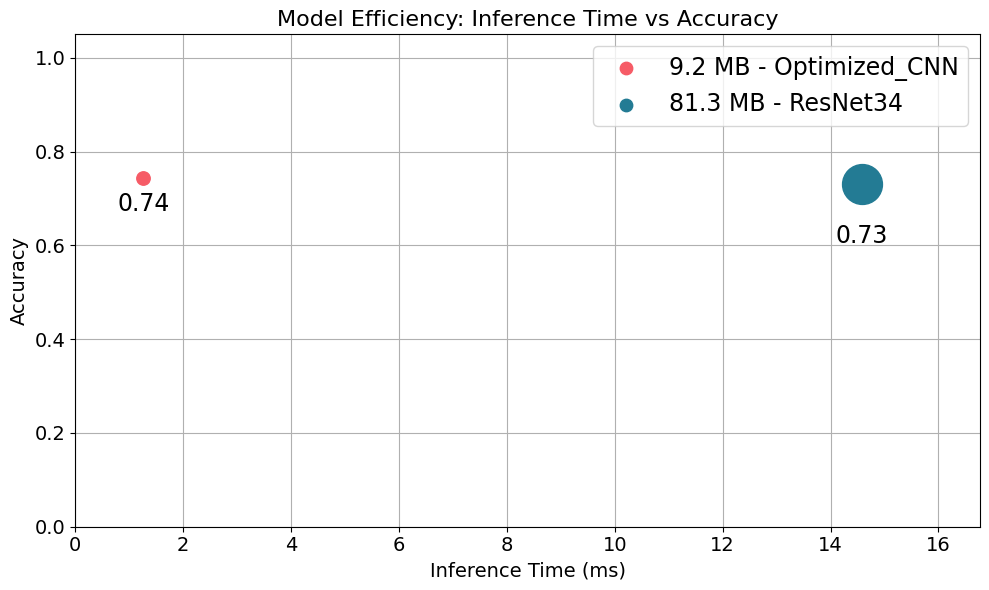

In [13]:
helper_utils.plot_efficiency_analysis(results_df)

### Selección de Modelos basada en restricciones y criterios ponderados

Cuando se consideran tanto el rendimiento como la eficiencia, la selección del modelo se convierte en una decisión multiobjetivo. 
En lugar de elegir un modelo basándose únicamente en el accuracy (precisión), es posible que desees tener en cuenta factores adicionales como el tamaño del modelo y el tiempo de inferencia.

En esta sección, se presenta una tabla que contiene varios modelos ResNet.  
Cada modelo tiene diferentes valores de tamaño, tiempo de inferencia y precisión.  
Aunque estos modelos no se entrenan dentro de este notebook (los valores son hipotéticos y podrían corresponder a resultados tras 100 épocas), puedes aplicar los mismos métodos de selección a cualquier conjunto de modelos, tal como hiciste con `OptimizedCNN` y `ResNet34`.

En las celdas de abajo encontrarás dos enfoques diferentes para la selección de modelos: `select_best_model_weighted` y `select_best_model_constraint_based`.

Estas funciones encapsulan los ingredientes principales de un flujo de trabajo robusto para la selección de modelos: conversión y normalización de métricas, ponderación flexible, aplicación de restricciones estrictas y un informe claro de los resultados. Este enfoque estructurado garantiza que los modelos se elijan de acuerdo tanto con los requisitos de la aplicación como con los recursos disponibles.

- `select_best_model_weighted`: Selecciona sistemáticamente el modelo óptimo combinando métricas normalizadas en una sola puntuación utilizando pesos personalizables.
    - La entrada `results` se convierte primero a un diccionario usando `results.to_dict(orient="index")`, lo que permite el acceso directo a las entradas del modelo.
    - Se pueden especificar los pesos de las métricas (por ejemplo, `weights = {"accuracy": 0.6, "model_size_mb": 0.2, "inference_time_ms": 0.2}`) o dejarlos por defecto para priorizar la precisión.
    - La normalización de cada métrica se realiza entre todos los modelos: 
        - Para el **"accuracy"**, se normaliza de modo que las puntuaciones más altas sean mejores usando:
          $norm\_value = (value - min\_val) / range\_val$
        - Para el **"model_size_mb"** e **"inference_time_ms"**, la normalización premia los valores más pequeños mediante:
          $norm\_value = 1 - (value - min\_val) / range\_val$

    - La suma ponderada para cada modelo se calcula como:
      $\sum (weights[metric] \times normalized[name][metric])$
      agregando la influencia de todas las métricas en función de su importancia.
    - El modelo con la puntuación combinada más alta se elige con:
      `best_model = max(scores.items(), key=lambda x: x[1])`.
    - La función devuelve tanto el nombre del mejor modelo como las puntuaciones de todos los modelos evaluados, proporcionando transparencia y flexibilidad para el análisis.

In [23]:
def select_best_model_weighted(results, weights=None):
    """Selecciona el mejor modelo de un conjunto de resultados utilizando un sistema de puntuación ponderada.

    Args:
        results: Un DataFrame de pandas que contiene las métricas de rendimiento del modelo,
                 con los nombres de los modelos como índice.
        weights: Un diccionario opcional donde las claves son nombres de métricas (por ejemplo,
                 'accuracy') y los valores son sus pesos correspondientes.
                 Si es None, se utilizan pesos por defecto.

    Returns:
        Una tupla que contiene el nombre del mejor modelo y un diccionario con las
        puntuaciones ponderadas de todos los modelos.
    """
    # Convertir el DataFrame a un diccionario para facilitar el procesamiento.
    results = results.to_dict(orient="index")
    
    # Si no se proporcionan pesos, definir un conjunto por defecto que priorice el accuracy.
    if weights is None:
        weights = {"accuracy": 0.5, "model_size_mb": 0.2, "inference_time_ms": 0.3}

    # Obtener la lista de métricas a considerar desde el diccionario de pesos.
    metrics = list(weights.keys())
    # Inicializar un diccionario para almacenar los valores de métricas normalizados para cada modelo.
    normalized = {name: {} for name in results}

    # Recorrer cada métrica para normalizar sus valores entre todos los modelos.
    for metric in metrics:
        # Extraer todos los valores para la métrica actual para encontrar el mínimo y el máximo.
        values = [res[metric] for res in results.values()]
        min_val, max_val = min(values), max(values)
        # Calcular el rango de valores, evitando la división por cero.
        range_val = max_val - min_val if max_val != min_val else 1.0

        # Iterar a través de los resultados de cada modelo para calcular su puntuación normalizada.
        for name, res in results.items():
            value = res[metric]
            # Verificar el tipo de métrica para determinar la dirección de la normalización.
            if metric == "accuracy":
                # Para el accuracy, los valores más altos son mejores, por lo que se normaliza directamente.
                norm_value = (value - min_val) / range_val
            else:
                # Para el tamaño y el tiempo, los valores más bajos son mejores, por lo que se invierte la normalización.
                norm_value = 1 - (value - min_val) / range_val
            # Almacenar el valor normalizado calculado.
            normalized[name][metric] = norm_value

    # Calcular la puntuación ponderada final para cada modelo.
    scores = {
        name: sum(weights[metric] * normalized[name][metric] for metric in metrics)
        for name in results
    }

    # Encontrar el modelo con la puntuación general más alta.
    best_model = max(scores.items(), key=lambda x: x[1])
    # Devolver el nombre del mejor modelo y el diccionario de todas las puntuaciones.
    return best_model[0], scores

- `select_best_model_constraint_based`: Selecciona el modelo más apropiado aplicando estrictamente restricciones de recursos antes de considerar el rendimiento.
    - La entrada `results` también se convierte en un diccionario mediante `results.to_dict(orient="index")` para el filtrado directo.
    - El código aplica restricciones duales, conservando los modelos solo si 
      `metrics["model_size_mb"] <= max_size_mb` y 
      `metrics["inference_time_ms"] <= max_inference_ms`.
    - Si ningún modelo satisface ambas restricciones, se imprime un mensaje para informar al usuario y la función devuelve `None`.
    - Entre los modelos viables, la selección se basa en el accuracy utilizando 
      `best_model = max(viable_models.items(), key=lambda x: x[1]["accuracy"])`.
    - La función devuelve el modelo con mayor precisión que cumple con las restricciones y una colección de todas las opciones viables.

In [20]:
def select_best_model_constraint_based(results, max_size_mb, max_inference_ms):
    """Selecciona el mejor modelo basado en restricciones estrictas de tamaño y tiempo de inferencia.

    Args:
        results: Un DataFrame de pandas con métricas de rendimiento del modelo.
        max_size_mb: El tamaño máximo permitido del modelo en megabytes.
        max_inference_ms: El tiempo de inferencia máximo permitido en milisegundos.

    Returns:
        Una tupla que contiene el nombre del mejor modelo y un diccionario de todos los
        modelos viables. Retorna None si ningún modelo cumple con las restricciones.
    """
    # Convertir el DataFrame a un diccionario para facilitar el procesamiento.
    results = results.to_dict(orient="index")
    
    # Filtrar los resultados para incluir solo modelos que satisfagan ambas restricciones.
    viable_models = {
        name: metrics for name, metrics in results.items()
        if metrics["model_size_mb"] <= max_size_mb and
           metrics["inference_time_ms"] <= max_inference_ms
    }

    # Verificar si algún modelo cumplió con las restricciones.
    if not viable_models:
        # Si ningún modelo es viable, notificar al usuario.
        print("No se encontraron modelos que cumplan con todas las restricciones. Considera relajar las restricciones.")
        return None

    # De la lista filtrada, seleccionar el modelo con el mayor accuracy.
    best_model = max(viable_models.items(), key=lambda x: x[1]["accuracy"])
    # Retornar el nombre del mejor modelo y todos los modelos que cumplieron las restricciones.
    return best_model[0], viable_models

- Ahora, ejecuta las dos funciones para seleccionar el mejor de los modelos ResNet basándose en las restricciones y criterios dados.

In [16]:
resnet_results = helper_utils.load_resnet_table()
resnet_results

,depth,accuracy,model_size_mb,inference_time_ms
model,,,,
ResNet18,18,0.92,42,2.0
ResNet34,34,0.93,81,3.8
ResNet50,50,0.94,98,5.0
ResNet101,101,0.95,168,8.0
ResNet152,152,0.96,230,12.0


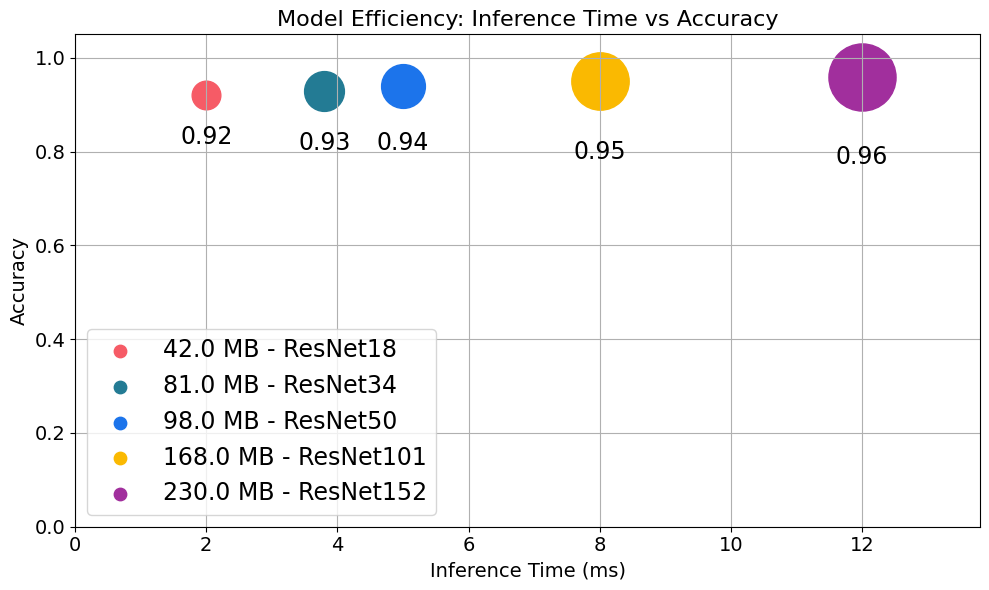

In [21]:
helper_utils.plot_efficiency_analysis(resnet_results)

Puedes ver que a medida que aumenta la profundidad del modelo (de ResNet-18 a ResNet-152), tanto el tamaño del modelo como el tiempo de inferencia aumentan. 
En otras palabras, los modelos más profundos tienden a ser más grandes y lentos.
Dependiendo de las restricciones de la aplicación (por ejemplo, inferencia en tiempo real frente a necesidades de accuracy), la selección del modelo adecuado requiere equilibrar la complejidad del modelo y la eficiencia.

Ahora puedes ejecutar las dos funciones para seleccionar el mejor modelo basándose en las restricciones y criterios dados.

In [24]:
best_model_weighted, weighted_scores = select_best_model_weighted(resnet_results)

print(f"Best model by weighted criteria: {best_model_weighted}")
print("Weighted scores:")
pprint(weighted_scores)

Best model by weighted criteria: ResNet50
Weighted scores:
{'ResNet101': 0.5609574468085103,
 'ResNet152': 0.5,
 'ResNet18': 0.5,
 'ResNet34': 0.5295106382978727,
 'ResNet50': 0.6004255319148929}


In [25]:
best_model_constrains, viable_models = select_best_model_constraint_based(resnet_results, max_size_mb=100, max_inference_ms=4)

print(f"Best model by constraints: {best_model_constrains}")
print("Viable models:")
pprint(viable_models)

Best model by constraints: ResNet34
Viable models:
{'ResNet18': {'accuracy': 0.92,
              'depth': 18,
              'inference_time_ms': 2.0,
              'model_size_mb': 42},
 'ResNet34': {'accuracy': 0.93,
              'depth': 34,
              'inference_time_ms': 3.8,
              'model_size_mb': 81}}


Observa que, dependiendo de las restricciones y los criterios, el modelo seleccionado puede variar.
Para los criterios ponderados, incluso si el ResNet-152 tiene el accuracy más alto, no es el que tiene la mejor puntuación (debido a su mayor tamaño y mayor tiempo de inferencia).

## Conclusión

¡Felicitaciones por llegar a la conclusión de este recorrido práctico sobre la selección de modelos y la evaluación de la eficiencia en PyTorch! Este notebook ha ilustrado no solo cómo entrenar y evaluar arquitecturas potentes de redes neuronales, sino también cómo sopesar las métricas de eficiencia críticas que afectan directamente el despliegue y la usabilidad del modelo.

Los pasos clave en este flujo de trabajo incluyeron el entrenamiento de modelos compactos y complejos, calculando los costos de recursos.
Además, se exploró la selección automatizada de modelos a través de funciones de objetivo ponderadas y el filtrado por restricciones estrictas, resaltando los compromisos (trade-offs) entre precisión, velocidad y consumo de memoria en diferentes escenarios.

Al trabajar en estas tareas, obtendrás una comprensión más rica y práctica de lo que se necesita para seleccionar el modelo más adecuado para una aplicación determinada. 
Estas técnicas permiten a los profesionales tomar decisiones informadas y basadas en datos, adaptadas a las restricciones tecnológicas y operativas del mundo real, sentando una base sólida para el diseño de sistemas de machine learning robustos y eficientes.